In [1]:
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [85]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]
def tableau_bin_n200(binn):
    a, b = binn
    return t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b)]

Mp, zp = 10**14.3, 0.5


In [92]:
t_amas_match = t_amas_match[t_amas_match['n200']>20]

In [93]:
reg = np.polyfit(np.log(t_amas_match['M']/Mp), np.log(t_amas_match['n200']), 1)

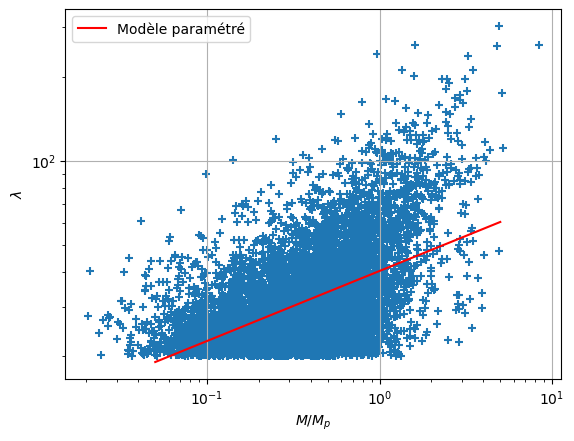

In [111]:
A, B = reg[1], reg[0]
m = np.logspace(13, 15, 10)
model = lambda m, A, B: np.exp(A+B*np.log(m/Mp))
plt.scatter(t_amas_match["M"]/Mp, t_amas_match["n200"], marker = '+')
plt.plot(m/Mp, model(m, A, B), color = 'r', label = 'Modèle paramétré')
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$M/ M_p$')
plt.legend()
plt.grid()
plt.show()

In [105]:
list_bin_M = []
Mi = np.logspace(13, 14, 11)
for i in range(len(Mi)-1):
    list_bin_M.append(t_amas_match[(t_amas_match['M']>Mi[i])&(t_amas_match['M']<Mi[i+1])])
print(Mi)

[1.00000000e+13 1.25892541e+13 1.58489319e+13 1.99526231e+13
 2.51188643e+13 3.16227766e+13 3.98107171e+13 5.01187234e+13
 6.30957344e+13 7.94328235e+13 1.00000000e+14]


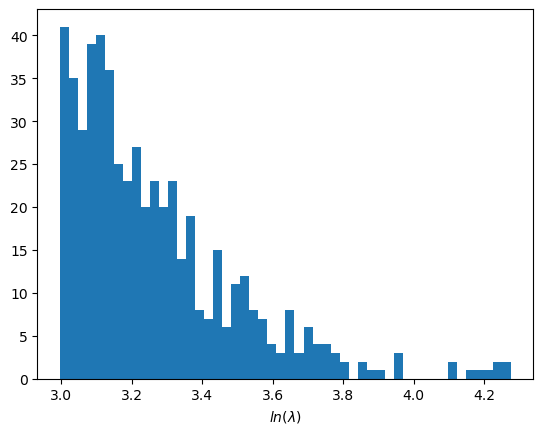

In [112]:
plt.hist(np.log(list_bin_M[5]['n200']), bins = 50)
plt.xlabel(r'$ln(\lambda)$')
plt.show()

In [107]:
M_Mp_bin_milieu = np.array([0.5*(Mi[i+1]+Mi[i])/Mp for i in range(len(list_bin_M)-1)])

In [108]:
list_std_bin = []
for binage in list_bin_M[:-1]:
    list_std_bin.append(np.std(np.log(binage['n200'])))
print(list_std_bin)

[np.float32(0.22719398), np.float32(0.21277437), np.float32(0.22655761), np.float32(0.20380019), np.float32(0.22787526), np.float32(0.23847836), np.float32(0.26108226), np.float32(0.26080492), np.float32(0.28481987)]


In [109]:
reg_std = np.polyfit(np.log(M_Mp_bin_milieu), list_std_bin, 1)

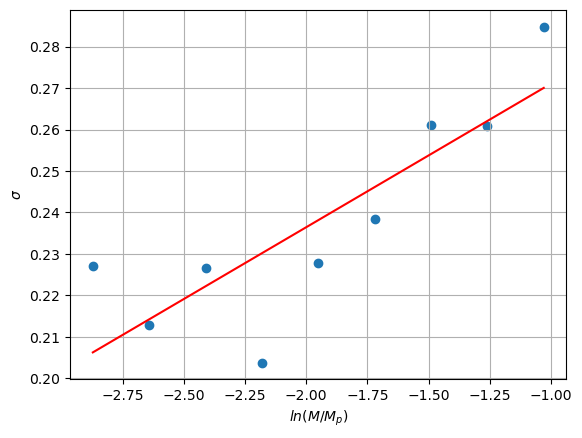

In [110]:

plt.scatter(np.log(M_Mp_bin_milieu), list_std_bin)
plt.plot([np.log(M_Mp_bin_milieu[0]), np.log(M_Mp_bin_milieu[-1])], [reg_std[0]*np.log(M_Mp_bin_milieu[0])+reg_std[1], reg_std[0]*np.log(M_Mp_bin_milieu[-1])+reg_std[1]], color = 'r')
plt.grid()
#plt.xscale('log')
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$ln(M/ M_p)$')
plt.show()

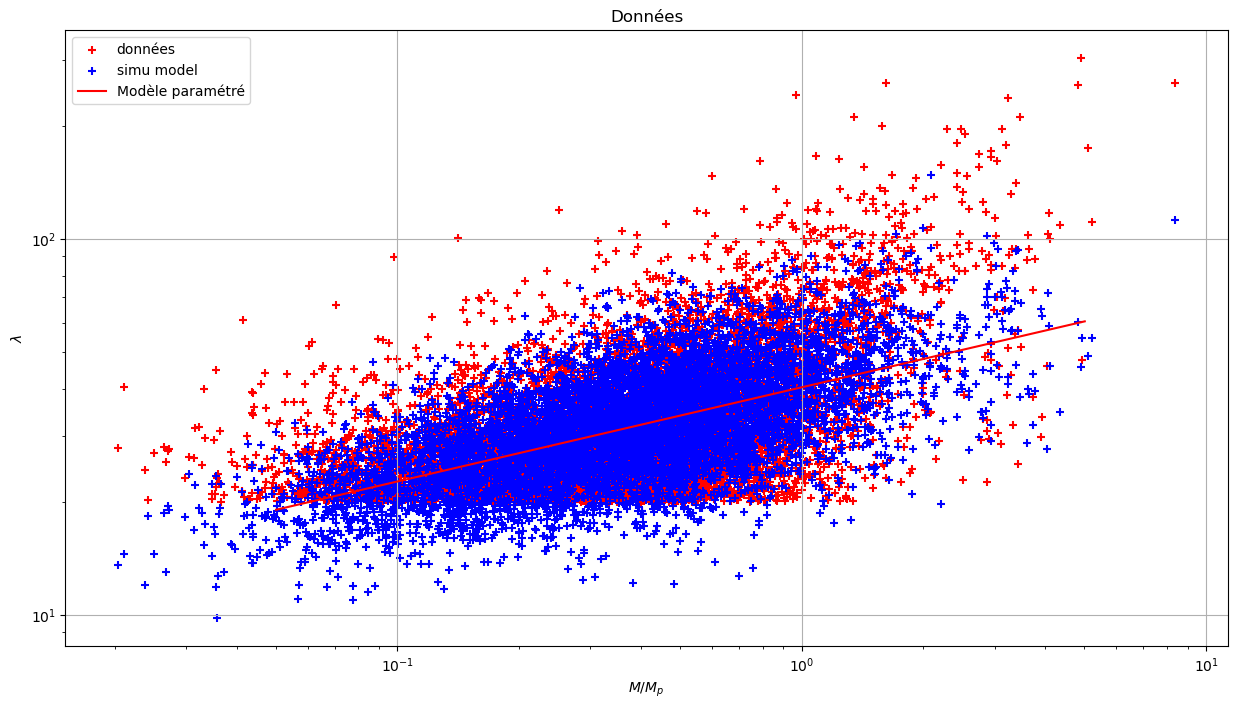

In [101]:
L = []
A, B = reg[1], reg[0]
D, E = reg_std[1], reg_std[0]
model_mean = lambda m, A, B: A+B*np.log(m/Mp)
model_std = lambda m, D, E: D+E*np.log(m/Mp)
for amas in t_amas_match:
    m_ = amas['M']
    moy, std = model_mean(m_, A, B), model_std(m_, D, E)
    L.append(np.exp(np.random.normal(moy, std, 1)[0]))

m = np.logspace(13, 15, 10)



A, B = reg[1], reg[0]
m = np.logspace(13, 15, 10)
model = lambda m, A, B: np.exp(A+B*np.log(m/Mp))



fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharex=False, sharey=True)

ax.set_title('Données')
ax.scatter(t_amas_match["M"]/Mp, t_amas_match["n200"], color = 'r', label = 'données', marker = '+')

ax.scatter(t_amas_match["M"]/Mp, L, color = 'b', label = 'simu model', marker = '+')
ax.plot(m/Mp, model(m, A, B), color = 'r', label = 'Modèle paramétré')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r'$\lambda$')
ax.set_xlabel(r'$M/ M_p$')
ax.legend()
ax.grid()


plt.show()

In [102]:
print('A =', A)
print('B =', B)
print('D =', D)
print('E =', E)


A = 3.6975283715676563
B = 0.25057303934868486
D = 0.29768922333621434
E = 0.032259679392605066


In [103]:
print(len(t_amas_match))
print(len(t_amas_match[t_amas_match['n200']>20]))

8090
8090


In [104]:
8090/19726

0.41011862516475717